In [105]:
import os
from typing import TypedDict, Annotated, List
#from langgraph.graph import Graph, END
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langchain_core.runnables.graph import MermaidDrawMethod
from datetime import datetime
import re
from newsapi import NewsApiClient
import requests
from bs4 import BeautifulSoup
from IPython.display import display, Image as IPImage
from langchain_core.messages import SystemMessage

In [106]:
from dotenv import load_dotenv

load_dotenv()

True

In [107]:
#os.environ['OPENAI_API_KEY'] = "YOUR_API_KEY"
OPEN_API_KEY= os.getenv("OPEN_API_KEY")
os.environ["PYTHONIOENCODING"] = "utf-8"
#invoke llm
llm = ChatOpenAI(
    model="gpt-4",     
    temperature=0.0,
    api_key=OPEN_API_KEY
)

class GraphState(TypedDict):
    news_query: Annotated[str, "Input query to extract news search parameters from."]
    num_searches_remaining: Annotated[int, "Number of articles to search for."]
    newsapi_params: Annotated[dict, "Structured argument for the News API."]
    past_searches: Annotated[List[dict], "List of search params already used."]
    articles_metadata: Annotated[list[dict], "Article metadata response from the News API"]
    scraped_urls: Annotated[List[str], "List of urls already scraped."]
    num_articles_tldr: Annotated[int, "Number of articles to create TL;DR for."]
    potential_articles: Annotated[List[dict[str, str, str]], "Article with full text to consider summarizing."]
    tldr_articles: Annotated[List[dict[str, str, str]], "Selected article TL;DRs."]
    formatted_results: Annotated[str, "Formatted results to display."]

In [108]:
class NewsApiParams(BaseModel):
    q: str = Field(description="1-3 concise keyword search terms that are not too specific")
    sources: str =Field(description="comma-separated list of sources from: 'abc-news,abc-news-au,associated-press,australian-financial-review,axios,bbc-news,bbc-sport,bloomberg,business-insider,cbc-news,cbs-news,cnn,financial-post,fortune'")
    from_param: str = Field(description="date in format 'YYYY-MM-DD' Two days ago minimum. Extend up to 30 days on second and subsequent requests.")
    to: str = Field(description="date in format 'YYYY-MM-DD' today's date unless specified")
    language: str = Field(description="language of articles 'en' unless specified one of ['ar', 'de', 'en', 'es', 'fr', 'he', 'it', 'nl', 'no', 'pt', 'ru', 'se', 'ud', 'zh']")
    sort_by: str = Field(description="sort by 'relevancy', 'popularity', or 'publishedAt'")

In [109]:
def generate_newsapi_params(state:GraphState):
    """This function generates News API params as per user's question."""

    #get today's date
    print('generate_news_paperi_parametrs node is running\n')
    today_date= datetime.now().strftime("%Y-%m-%d")
    news_query=state['news_query']
    num_searches_remaining= state['num_searches_remaining']
    past_searches = state["past_searches"]
    last_req = state.get('latest_newsapi_params', None)

    sys_prompt="""
    Today's date is {today_date}
     Create a param dict for the News API on the user query:
     {query}

     These searches have already been made. Loosen the search terms to get more results.
     {past_searches}

     Including this one, you have {num_searches_remaining} searches remaining. If this is your last search, use all news resources and 30 days search range.
"""
    
    sys_msg= sys_prompt.format(today_date=today_date,query=news_query, past_searches=past_searches,num_searches_remaining=num_searches_remaining)

    llm_with_news_structured_output= llm.with_structured_output(NewsApiParams)

    result=llm_with_news_structured_output.invoke([SystemMessage(content=sys_msg)])

    params={'q':result.q,
    "sources": result.sources,
    "from_param":result.from_param,
    "to":result.to,
    "language":result.language,
    "sort_by":result.sort_by}
    q_lower = news_query.lower()
    import re
    if re.search(r"[a-zA-Z]+\s*\d", q_lower):
        params["q"] = f"\"{news_query}\" OR {news_query.split()[0]}"
        params.pop("sources", None)

    # --- Broaden if we’re repeating the same params as last time
    if last_req and params.get("q") == last_req.get("q") and params.get("sources") == last_req.get("sources"):
        params.pop("sources", None)
        if "OR" not in params["q"]:
            params["q"] = f"{params['q']} OR {news_query}"

    #state["newsapi_params"] = params

    state['newsapi_params']=params
    #print(state)
    print('generate_news_api_parameters output:', state,'\n')

    return state

In [110]:
def retrieve_article_metadata(state:GraphState):
    """This gives metadata about the articles"""
    
    print('retrieve_articles_metadata node is running\n')
    newsapi_params= state['newsapi_params']
    scraped_urls= state["scraped_urls"]
    potential_articles = state['potential_articles']
    past_searches= state['past_searches']
        
    #initiate NewsAPI Client
    newsapi= NewsApiClient(api_key='a2bc722921184ff9a6ec21fbd0ed2f83')
        
        #get the articles
    articles= newsapi.get_everything(**newsapi_params)
    #print("Articles fetched:", articles)
    #add the parameters for the history
    past_searches.append(newsapi_params)

    new_articles = []
        
    for article in articles['articles']:
        if article['url'] not in scraped_urls and len(potential_articles) + len(new_articles) < 10:
            new_articles.append(article)
    #print('retrive_articles_metadata node is running\n')
    #state['articles_metadata']= new_articles
    print('retrieved articles metadata:', new_articles)
    return {'articles_metadata': new_articles, 'past_searches': past_searches }


In [111]:
def retrieve_article_text(state:GraphState):
    """scrape the websites metadata"""


    print('retrieve_article_text node is running\n')
    article_metadata= state['articles_metadata']
    scraped_urls= state['scraped_urls']
    potential_articles=state['potential_articles']
    potential_articles_n = []
    #header for scraping
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'
    }
    print("article metadata:", article_metadata)
    for article in article_metadata:
        url= article['url']
        response= requests.get(url, headers=headers)

        if response.status_code == 200:
            soup= BeautifulSoup(response.content, 'html.parser')

            text= soup.get_text(strip=True)

            potential_articles_n.append({"title": article["title"], "url": url, "description": article["description"], "text": text})

            #state['scraped_urls'].append(url)
            scraped_urls.append(url)
        else:
            print("status code is not 200")
    potential_articles.extend(potential_articles_n)
    print('potentisal articles after retrieval:', potential_articles, 'scraed_urls:', scraped_urls)
    return {'potential_articles': potential_articles, 'scraped_urls':scraped_urls }

In [112]:
# def select_top_urls(state: GraphState) -> GraphState:
#     """Based on the article synoses, choose the top-n articles to summarize."""
#     print('select_top_urls node is running\n')
#     news_query = state["news_query"]
#     num_articles_tldr = state["num_articles_tldr"]
    
#     # load all processed articles with full text but no summaries
#     potential_articles = state["potential_articles"]

#     # format the metadata
#     formatted_metadata = "\\n".join([f"{article['url']}\\n{article['description']}\\n" for article in potential_articles])

#     prompt = f"""
#     Based on the user news query:
#     {news_query}

#     Reply with a list of strings of up to {num_articles_tldr} relevant urls.
#     Don't add any urls that are not relevant or aren't listed specifically.
#     {formatted_metadata}
#     """
#     result = llm.invoke(prompt).content

#     # use regex to extract the urls as a list
#     url_pattern = r'(https?://[^\\s",]+)'

#     # Find all URLs in the text
#     urls = re.findall(url_pattern, result)

#     # add the selected article metadata to the state
#     tldr_articles = [article for article in potential_articles if article['url'] in urls]

#     #state["tldr_articles"] = tldr_articles
#     print('selected tldr articles:', tldr_articles)
#     #print(state['tldr_articles'])
#     return {
#         "tldr_articles": tldr_articles
#     }

In [113]:
def select_top_urls(state: GraphState) -> GraphState:
    """Choose up to num_articles_tldr articles to summarize, robustly."""
    print('select_top_urls node is running\n')
    news_query = state["news_query"]
    num_articles_tldr = state["num_articles_tldr"]
    potential_articles = state["potential_articles"]

    # Gather candidate URLs exactly as seen by the model
    candidate_urls = [a["url"] for a in potential_articles]
    formatted_metadata = "\n".join(
        f"{a['url']}\n{a.get('description','')}\n" for a in potential_articles
    )

    # Try to coerce the model into returning JUST a JSON list of URLs
    prompt = f"""
Return ONLY a valid JSON list of up to {num_articles_tldr} URLs from the list below
that best match the user query. Do NOT include any text before or after the JSON.

User query:
{news_query}

Candidate URLs with descriptions:
{formatted_metadata}
"""
    raw = llm.invoke(prompt).content

    # Parse JSON list fallback to regex if needed
    urls = []
    try:
        import json
        parsed = json.loads(raw.strip())
        if isinstance(parsed, list):
            urls = [u for u in parsed if isinstance(u, str)]
    except Exception:
        pass

    if not urls:
        # regex fallback
        url_pattern = r'(https?://[^\s",\]\)]+)'
        urls = re.findall(url_pattern, raw)

    # Keep only URLs we actually scraped
    urlset = set(candidate_urls)
    urls = [u for u in urls if u in urlset]

    # FINAL FALLBACK: pick top-N by simple keyword score if nothing was selected
    if not urls:
        q_tokens = [t for t in re.split(r"[^a-z0-9]+", news_query.lower()) if t and t not in {"and", "or", "the"}]
        def score(a):
            text = f"{a.get('title','')} {a.get('description','')}".lower()
            return sum(text.count(t) for t in q_tokens)
        ranked = sorted(potential_articles, key=score, reverse=True)
        urls = [a["url"] for a in ranked[:num_articles_tldr]]

    tldr_articles = [a for a in potential_articles if a["url"] in urls]
    print('selected tldr articles:', [a["url"] for a in tldr_articles])
    return {"tldr_articles": tldr_articles}


In [114]:
def summarize_articles_parallel(state: GraphState) -> GraphState:
    """Summarize the articles based on full text."""
    tldr_articles = state["tldr_articles"]

    prompt = """
    Create a * bulleted summarizing tldr for the article:
    {text}
      
    Be sure to follow the following format exaxtly with nothing else:
    {title}
    {url}
    * tl;dr bulleted summary
    * use bullet points for each sentence
    """

    # iterate over the selected articles and collect summaries synchronously
    for i in range(len(tldr_articles)):
        text = tldr_articles[i]["text"]
        title = tldr_articles[i]["title"]
        url = tldr_articles[i]["url"]
        # invoke the llm synchronously
        result = llm.invoke(prompt.format(title=title, url=url, text=text))
        tldr_articles[i]["summary"] = result.content

    #state["tldr_articles"] = tldr_articles
    #print(state['tldr_articles'])
    print('summarize_articles_parallel node is running\n')
    print('summarized tldr articles:', state['tldr_articles'])
    return {
        "tldr_articles": tldr_articles
    }

In [115]:
def format_results(state: GraphState) -> GraphState:
    """Format the results for display."""
    # load a list of past search queries
    q = [newsapi_params["q"] for newsapi_params in state["past_searches"]]
    formatted_results = f"Here are the top {len(state['tldr_articles'])} articles based on search terms:\\n{', '.join(q)}\\n\\n"

    # load the summarized articles
    tldr_articles = state["tldr_articles"]

    # format article tl;dr summaries
    tldr_articles = "\\n\\n".join([f"{article['summary']}" for article in tldr_articles])

    # concatenate summaries to the formatted results
    formatted_results += tldr_articles

    #state["formatted_results"] = formatted_results
    #print(state['formatted_results'])
    print('format_results node is running\n')
    return {
        "formatted_results": formatted_results
    }

In [116]:
# def format_results(state: GraphState) -> GraphState:
#     """Format the results for display."""
#     # load a list of past search queries
#     q = [newsapi_params["q"] for newsapi_params in state["past_searches"]]
#     formatted_results = f"Here are the top {len(state['tldr_articles'])} articles based on search terms:\\n{', '.join(q)}\\n\\n"

#     # load the summarized articles
#     tldr_articles = state["tldr_articles"]

#     # format article tl;dr summaries
#     tldr_articles = "\\n\\n".join([f"{article['summary']}" for article in tldr_articles])

#     # concatenate summaries to the formatted results
#     formatted_results += tldr_articles

#     state["formatted_results"] = formatted_results

#     return state

In [117]:
def articles_text_decision(state: GraphState) -> str:
    """Check results of retrieve_articles_text to determine next step."""
    
    print('articles_text_decision condition is running\n')
    if state["num_searches_remaining"] == 0:
        # if no articles with text were found return END
        if len(state["potential_articles"]) == 0:
            state["formatted_results"] = "No articles with text found."
            return "END"
        # if some articles were found, move on to selecting the top urls
        else:
            return "select_top_urls"
    else:
        # if the number of articles found is less than the number of articles to summarize, continue searching
        if len(state["potential_articles"]) < state["num_articles_tldr"]:
            return "generate_newsapi_params"
        # otherwise move on to selecting the top urls
        else:
            return "select_top_urls"
    #print('articles_text_decision condition is running\n')
    #print(state['potential_articles'])

In [118]:
workflow = StateGraph(GraphState)

#define nodes
workflow.add_node("generate_newsapi_params", generate_newsapi_params)
workflow.add_node("retrieve_articles_metadata", retrieve_article_metadata)
workflow.add_node("retrieve_articles_text", retrieve_article_text)
workflow.add_node("select_top_urls", select_top_urls)
workflow.add_node("summarize_articles_parallel", summarize_articles_parallel)
workflow.add_node("format_results", format_results)

#define edges
workflow.add_edge(START, "generate_newsapi_params")
workflow.add_edge("generate_newsapi_params", "retrieve_articles_metadata")
workflow.add_edge("retrieve_articles_metadata", "retrieve_articles_text")
workflow.add_conditional_edges(
    "retrieve_articles_text",
    articles_text_decision,
    {
        "generate_newsapi_params": "generate_newsapi_params",
        "select_top_urls": "select_top_urls",
        "END": END
    }
    )
workflow.add_edge("select_top_urls", "summarize_articles_parallel")
workflow.add_conditional_edges(
    "summarize_articles_parallel",
    lambda state: "format_results" if len(state["tldr_articles"]) > 0 else "END",
    {
        "format_results": "format_results",
        "END": END
    }
    )
workflow.add_edge("format_results", END)
app=workflow.compile()

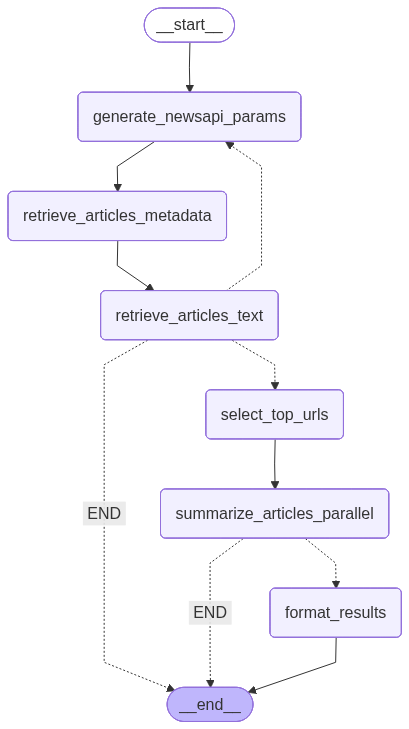

In [119]:
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image, display

png_bytes = app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)
display(Image(png_bytes))


In [120]:
def run_workflow(query: str, num_searches_remaining: int = 3, num_articles_tldr: int = 2):
    """Run the LangGraph workflow and display results."""
    initial_state = {
        "news_query": query,
        "num_searches_remaining": num_searches_remaining,
        "newsapi_params": {},
        "past_searches": [],
        "articles_metadata": [],
        "scraped_urls": [],
        "num_articles_tldr": num_articles_tldr,
        "potential_articles": [],
        "tldr_articles": [],
        "formatted_results": "No articles with text found."
    }
    try:
        result = app.invoke(initial_state, config={"recursion_limit": 10})
        
        return result["formatted_results"]
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

In [123]:
# diag_state =app.invoke({
#     "news_query": "weather in New York City",
#     "num_searches_remaining": 2,
#     "newsapi_params": {},
#     "past_searches": [],
#     "articles_metadata": [],
#     "scraped_urls": [],
#     "num_articles_tldr": 3,
#     "potential_articles": [],
#     "tldr_articles": [],
#     "formatted_results": ""
# }, config={"recursion_limit": 40})
 
# print("last_newsapi_request =", diag_state.get("last_newsapi_request"))
# print("last_newsapi_error   =", diag_state.get("last_newsapi_error"))
# print("last_scrape_error    =", diag_state.get("last_scrape_error"))
# print("metadata len         =", len(diag_state.get("articles_metadata", [])))
# print("potential len        =", len(diag_state.get("potential_articles", [])))
# print("tldr len             =", len(diag_state.get("tldr_articles", [])))

In [122]:
#query = "red fort delhi blast"
query = '(India OR Delhi) AND (AI OR artificial intelligence) AND (policy OR regulation OR guidelines)'
result=run_workflow(query, num_articles_tldr=10)
print(result)

generate_news_paperi_parametrs node is running

generate_news_api_parameters output: {'news_query': '(India OR Delhi) AND (AI OR artificial intelligence) AND (policy OR regulation OR guidelines)', 'num_searches_remaining': 3, 'newsapi_params': {'q': '(India OR Delhi) AND (AI OR artificial intelligence) AND (policy OR regulation OR guidelines)', 'sources': 'abc-news,abc-news-au,associated-press,australian-financial-review,axios,bbc-news,bbc-sport,bloomberg,business-insider,cbc-news,cbs-news,cnn,financial-post,fortune', 'from_param': '2025-10-11', 'to': '2025-11-10', 'language': 'en', 'sort_by': 'relevancy'}, 'past_searches': [], 'articles_metadata': [], 'scraped_urls': [], 'num_articles_tldr': 10, 'potential_articles': [], 'tldr_articles': [], 'formatted_results': 'No articles with text found.'} 

retrieve_articles_metadata node is running

retrieved articles metadata: [{'source': {'id': 'business-insider', 'name': 'Business Insider'}, 'author': 'Melia Russell', 'title': 'An ex-Microsof